In [ ]:
 # Проверка среды выполнения СoLab/Local
oncolab = 'google.colab' in str(get_ipython())
if oncolab:
  print('Running on CoLab')
else:
  print('Not running on CoLab')

Running on CoLab


In [ ]:
!pip install uproot3 awkward particle scikit-learn 'iminuit<2' probfit cupy-cuda110

     |████████████████████████████████| 122kB 6.8MB/s 
     |████████████████████████████████| 8.1MB 12.2MB/s 
     |████████████████████████████████| 215kB 42.2MB/s 
     |████████████████████████████████| 4.1MB 40.2MB/s 
     |████████████████████████████████| 1.8MB 42.7MB/s 
     |████████████████████████████████| 165.3MB 82kB/s 
     |████████████████████████████████| 92kB 10.7MB/s 


In [ ]:
# Импорт Tensoflow и инициализация вычислительных устройств для нейросети
import tensorflow as tf

print('Tensorflow version:', tf.version.VERSION)
phys_devs = tf.config.experimental.list_physical_devices()
phys_gpus = tf.config.experimental.list_physical_devices('GPU')

if phys_gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        phys_gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

logical_devs = tf.config.experimental.list_logical_devices()
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(len(phys_gpus), " Physical GPUs,", len(logical_gpus), " Logical GPUs")
print('Physical devices:',' '.join([d.name for d in phys_devs]))
print('Physical GPUs:',' '.join([d.name for d in phys_gpus]))
print('Logical devices:',' '.join([d.name for d in logical_devs]))
print('Logical GPUs:',' '.join([d.name for d in logical_gpus]))
#tf.debugging.set_log_device_placement(True)

Tensorflow version: 2.4.1
0  Physical GPUs, 0  Logical GPUs
Physical devices: /physical_device:CPU:0
Physical GPUs: 
Logical devices: /device:CPU:0
Logical GPUs: 


In [ ]:
# Подключение библиотек
import os, timeit, glob, shutil
from math import *
import uproot3 as uproot
import itertools
import numpy as np
from numpy.random import random
import numpy.linalg as la
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
from operator import itemgetter
import scipy
from scipy.stats import norm
#import matplotlib.patches as mpatches
#from mpl_toolkits import mplot3d
from sklearn.model_selection import train_test_split
from tensorflow import keras
from particle import Particle
from iminuit import Minuit
from probfit import BinnedLH, gaussian

#%load_ext tensorboard
#%matplotlib notebook
print('Uproot version:',uproot.version.version)
print('Numpy version:', np.version.version)

plt.rcParams['font.size'] = '14'

Uproot version: 3.14.4
Numpy version: 1.19.5


In [ ]:
#@title Текст заголовка по умолчанию
nphibins = 8 #@param {type:"integer"}libxcb-xtest0

verbose = False #@param {type:"boolean"}

updateEDF = False #@param {type:"boolean"}

updateCal = False #@param {type:"boolean"}

In [ ]:
'''
momenta = ["500","600","700","850","1000","1500","2000"] #Mev
N_momenta = len(momenta)

thetas_p = ["0","15","30","45"]
N_thetas = len(thetas_p)

mass_mu = Particle.from_pdgid(13).mass
mass_pi = Particle.from_pdgid(211).mass

beta = []
beta_from_p = dict()
for momentum in momenta:
  beta_mu = float(momentum)/np.sqrt(mass_mu**2 + float(momentum)**2)
  beta_pi = float(momentum)/np.sqrt(mass_pi**2 + float(momentum)**2)
  beta.append(beta_mu) 
  beta.append(beta_pi)
  beta_from_p[momentum + '_mu'] = beta_mu
  beta_from_p[momentum + '_pi'] = beta_pi
#beta.sort()
N_betas = len(beta)
'''


'\nmomenta = ["500","600","700","850","1000","1500","2000"] #Mev\nN_momenta = len(momenta)\n\nthetas_p = ["0","15","30","45"]\nN_thetas = len(thetas_p)\n\nmass_mu = Particle.from_pdgid(13).mass\nmass_pi = Particle.from_pdgid(211).mass\n\nbeta = []\nbeta_from_p = dict()\nfor momentum in momenta:\n  beta_mu = float(momentum)/np.sqrt(mass_mu**2 + float(momentum)**2)\n  beta_pi = float(momentum)/np.sqrt(mass_pi**2 + float(momentum)**2)\n  beta.append(beta_mu) \n  beta.append(beta_pi)\n  beta_from_p[momentum + \'_mu\'] = beta_mu\n  beta_from_p[momentum + \'_pi\'] = beta_pi\n#beta.sort()\nN_betas = len(beta)\n'

In [ ]:
 if oncolab:
  from google.colab import drive 
  drive.mount('/mntDrive')  # смонтировать диск в папке «mntDrive»   
  datadir = '/mntDrive/My Drive/FARICH/Reconstruction/NN/data'
else:
  datadirs = [r'C:\Users\skono\Google Диск (skononov@nsu.ru)\FARICH\Reconstruction\NN\data', \
              r'D:\skono\Google Диск НГУ\FARICH\Reconstruction\NN\data', \
              r'C:\Users\skono\Google Диск НГУ\FARICH\Reconstruction\NN\data']
  datadir = None
  for dir in datadirs:
    if os.access(dir, os.R_OK):
      datadir = dir
      break

Mounted at /mntDrive


In [ ]:
# отображение ключей в файле uproot в виде иерархии
def show_uproot_tree(obj, maxkeylen=12, sep='/', indent=0):
  width = maxkeylen+len(sep)
  startline = False
  if isinstance(obj, uproot.rootio.ROOTDirectory):
    print('TFile: '+obj.name.decode('utf-8'))
    startline = True
    indent = 2
  elif issubclass(type(obj), uproot.tree.TTreeMethods):
    print('TTree: '+obj.name.decode('utf-8'))
    startline = True
    indent = 4
  else:
    if len(obj.keys()) > 0:
      indent += width
      s = obj.name.decode('utf-8')[:maxkeylen]
      print(s + ' '*(maxkeylen-len(s)) + sep, end='')
    else:
      print(obj.name.decode('utf-8'))

  if len(obj.keys()) > 0:
    for i, key in enumerate(obj.keys()):
      if i>0 or startline:
        print(' '*indent, end='')
      show_uproot_tree(obj[key], indent=indent)
    indent -= width

In [ ]:
filename = os.path.join(datadir,'mu-pi-','theta_45','farichsim_mu-pi-_1500MeV_45-90deg_20.0k_ideal_2020-12-07_rndm.root')
show_uproot_tree(uproot.open(filename))

TFile: ./farichsim_mu-pi-_1500MeV_45-90deg_20.0k_ideal_2020-12-07_rndm.root
  TTree: info_sim
    info_gen    /m_num_events
                 m_z_dis
    info_rad    /m_layers    /m_layers.first
                              m_layers.second
    info_pmt    /m_name
                 m_num_side_x
                 m_num_side_y
                 m_gap
                 m_size
                 m_chip_num_size
                 m_chip_pitch
                 m_chip_size
                 m_chip_offset
                 m_focal_length
                 m_trg_window
                 m_origin_pos/m_origin_pos._2
                              m_origin_pos._1
                              m_origin_pos._0
  TTree: raw_data
    event       /m_id_event
                 m_id_primary
                 m_pos_primar/m_pos_primary._2
                              m_pos_primary._1
                              m_pos_primary._0
                 m_dir_primar/m_dir_primary._2
                              m_dir_primar

In [ ]:
def processroot(rootfilenames, edfilename: str, entrystop=None, nfrac: float=1.0, depthfrac: float=0.6, verbose: bool=False):
  assert(nfrac>=0 and nfrac<=1)
  assert(depthfrac>=0 and depthfrac<=1)

  rename_map = {'m_beta_primary': 'beta', 'm_theta_primary': 'theta_p', 'm_momentum_primary': 'momentum',
                'm_pos_primary._0': 'x_p', 'm_pos_primary._1': 'y_p', 'm_pos_primary._2': 'z_p', 
                'm_dir_primary._0': 'nx_p', 'm_dir_primary._1': 'ny_p', 'm_dir_primary._2': 'nz_p', 
                'm_hits.m_photon_pos_chip._0': 'x_h','m_hits.m_photon_pos_chip._1': 'y_h', 'm_hits.m_photon_pos_chip._2': 'z_h'}

  coltosave = ['beta', 'theta_p', 'theta_c', 'phi_c']
  W = l = n = None
  eventchunksize = 50000

  entriesRead = 0
  store = pd.HDFStore(edfilename, 'w')
  try:
    nfiles = len(rootfilenames)
    append = False
    for i, filename in enumerate(rootfilenames):
      print(f'Processing file {filename}...')
      with uproot.open(filename) as file:
        if W is None:
          # Получение параметров (многослойного) радиатора одинаковых для всех файлов
          n_l = file[b'info_sim/info_rad/m_layers/m_layers.first'].array()[0] #показатели преломления слоёв
          w_l = file[b'info_sim/info_rad/m_layers/m_layers.second'].array()[0] #толщина слоёв радиатора
          rad_pos = file[b'info_sim/info_gen/m_z_dis'].array()[0] #смещение радиатора по Z относительно начала координат
          distance = file[b'info_sim/info_pmt/m_focal_length'].array()[0] #расстояние от входной поверхности радиатора до ФД
          W = w_l.sum() #суммарная толщина всех слоёв
          n_mean = n_l.mean() #средний показатель преломления
          n_max = n_l.max() #максимальный показатель преломления
          L = distance - W #ширина воздушного промежутка
          l = depthfrac * W #эффективная глубина выхода фотонов, отсчитываемая от входной поверхности, для реконструкции
          n = nfrac * n_max + (1-nfrac) * n_mean #эффективный показатель преломления для реконструкции

          print(f'Radiator parameters: Nlayers = {n_l.size}, n_max = {n_max}, n_mean={n_mean}, W={W}')
          print(f'Parameters used for reconstruction: n={n:.5f}, depth={l:.2f}mm')

      chunk = 0
      for edf in uproot.pandas.iterate(filename, "raw_data", rename_map.keys(), entrysteps=eventchunksize, flatten=True):
        print(f'Processing chunk {chunk} with {edf.index.levels[0].size} events...')
        if verbose:
          print(edf)

        # число прочитанный событий
        entriesRead += edf.index.levels[0].size

        # число хитов
        N = edf.shape[0]

        # Получение координат срабатываний и частиц и направления частиц в виде массивов numpy
        edf.rename(columns=rename_map, inplace=True, errors='raise')

        r0 = edf.loc[:, ('x_p', 'y_p', 'z_p')].values
        n0 = edf.loc[:, ('nx_p', 'ny_p', 'nz_p')].values
        r_h = edf.loc[:, ('x_h', 'y_h', 'z_h')].values

        # Номинальная точка вылета фотонов
        ro = r0 + n0 * (l + rad_pos)/n0[:,2].reshape(N,1)

        # Косинусы и синусы сферических углов направления частицы
        costheta, sintheta = n0[:,2] , np.sqrt(n0[:,0]**2+n0[:,1]**2)
        phi = np.arctan2(n0[:,1], n0[:,0])
        cosphi, sinphi = np.cos(phi), np.sin(phi)

        r = np.sqrt((r_h[:,0] - ro[:,0])**2 + (r_h[:,1] - ro[:,1])**2)

        if abs(W-l) > 1e-8:
          a = r/(W-l)
          c = L/(W-l)
          # 0-е приближение к tan(alpha)
          t = r/(L+W-l)
          # 3 итерации для нахождения tan(alpha)
          t = 1/np.sqrt((n*c/(a-t))**2 + n**2 - 1)
          t = 1/np.sqrt((n*c/(a-t))**2 + n**2 - 1)
          t = 1/np.sqrt((n*c/(a-t))**2 + n**2 - 1)
        else:
          t = 1/np.sqrt((n*L/r)**2 + n**2 - 1)

        cosalpha = 1/np.sqrt(1+t**2)
        sinalpha = 1/np.sqrt(1+1/t**2)

        vz = cosalpha
        vx = (r_h[:,0] - ro[:,0])/r*sinalpha
        vy = (r_h[:,1] - ro[:,1])/r*sinalpha

        ux = costheta*(vx*cosphi + vy*sinphi) - vz*sintheta
        uy = -vx*sinphi + vy*cosphi
        uz = sintheta*(vx*cosphi + vy*sinphi) + vz*costheta

        theta_c = np.arccos(uz)
        phi_c = np.arctan2(-uy, -ux)

        edf['theta_c'] = theta_c
        edf['phi_c'] = phi_c 

        event_cut = edf['theta_c'] < acos(1/n_max)*1.1

        # ужать размер data frame
        edf = edf.loc[event_cut, coltosave]

        store.put('edf', edf, format='table', append=append)
        append = True

        if isinstance(entrystop, int):
          entriesToRead = entrystop - entriesRead
          if entriesToRead <= 0:
            print('Requested number of entries was read')
            break

        chunk += 1

  finally:
    store.close()
  print(f'Total {entriesRead} events was read and reconstructed.')


In [ ]:
def gaussbg(x, *p):
    A, mu, sigma, C, B = p
    return A*norm.pdf(x,loc=mu,scale=sigma) + C*x + B

In [ ]:
def makecal(edf, nphibins: int, drawhist: bool = False, drawcurve: bool = False, verbose: bool = False):
  h = 2*pi/nphibins

  print('Make calibration of theta_c')

  edf_cut = edf.rename(columns={'beta': 'beta_cal', 'theta_p': 'theta_p_cal'})

  edf_cut['phi_c_cal'] = 2*pi*np.floor((edf['phi_c']+pi)/h)/nphibins-pi+h/2

  print('  Groupping...')
  groups = edf_cut.groupby(['beta_cal','theta_p_cal','phi_c_cal'])

  if drawhist:
    nxhplots = nphibins//2
    nyhplots = nbetas*2
    figh = plt.figure(figsize=(nxhplots*4, nyhplots*4))
    iploth = 1

  if drawcurve:
    nxcplots = nthetas
    nycplots = nbetas
    figc = plt.figure(figsize=(nxcplots*4, nycplots*4))
    iplotc = 1
  
  weightedSum = {}
  weightedSumSquares = {}
  sumWeights = {}

  caldf = pd.DataFrame(np.zeros((nbetas*nthetas*nphibins, 5)), columns=('beta_cal', 'theta_p_cal', 'phi_c_cal', 'mean_theta_c', 'sigma_theta_c'))
  ibin = 0
  fillFromNextValues = False
  for (beta_cal, theta_p_cal, phi_c_cal), data in groups:
    print(f'  Process group with (beta_cal, theta_p_cal, phi_c_cal) = ({beta_cal:.4f}, {theta_p_cal*180/pi:.0f}, {phi_c_cal*180/pi:.1f})')

    print('    Cutting on theta_c')

    theta_cut = data['theta_c']

    k = 0
    while(k<3):
      theta_mean = theta_cut.mean()
      theta_std = theta_cut.std()
      theta_cut = theta_cut[(theta_cut>(theta_mean-3*theta_std)) & (theta_cut<(theta_mean+3*theta_std))]
      k+=1
    
    hist, bin_edges = np.histogram(theta_cut, bins=100, density=False)
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

    # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
    p0 = [hist.max()*sqrt(2*pi)*0.01, bin_centres[np.argmax(hist)], 0.01, 0., 0.]

    pars, pcov = curve_fit(gaussbg, bin_centres, hist, p0=p0, sigma=np.sqrt(hist)+1, absolute_sigma=True) 
    errors = np.sqrt(np.diag(pcov))

    mean, sigma = pars[1], pars[2]
    err_mean, err_sigma = errors[1], errors[2]
    print(f'    mean_theta_c={mean:.3f}+-{err_mean:.3f}, sigma_theta_c={sigma:.3f}+-{err_sigma:.3f}')

    if sigma==0 or np.isnan(err_sigma):
      print(f'Null sigma fitted, use adjacent mean&sigma.')
      if ibin%nphibins == 0:
        fillFromNextValues = True
      else:
        mean = caldf.at[ibin-1, 'mean_theta_c']
        sigma = caldf.at[ibin-1, 'sigma_theta_c']
    elif fillFromNextValues:
      fillFromNextValues = False
      caldf.at[ibin-1, 'mean_theta_c'] = mean
      caldf.at[ibin-1, 'sigma_theta_c'] = sigma

    if beta_cal in sumWeights:
      weightedSum[beta_cal] += sin(theta_p_cal)*mean/sigma**2
      weightedSumSquares[beta_cal] += sin(theta_p_cal)*(mean/sigma)**2
      sumWeights[beta_cal] += sin(theta_p_cal)/sigma**2
    else:
      weightedSum[beta_cal] = sin(theta_p_cal)*mean/sigma**2
      weightedSumSquares[beta_cal] = sin(theta_p_cal)*(mean/sigma)**2
      sumWeights[beta_cal] = sin(theta_p_cal)/sigma**2

    caldf.at[ibin, :] = [beta_cal, theta_p_cal, phi_c_cal, mean, sigma]

    if drawhist and ibin%nphibins >= nphibins//2 and (ibin//nphibins)%nthetas > 1:
      ax = figh.add_subplot(nyhplots, nxhplots, iploth)
      iploth += 1
      plt.title(fr'$\beta={beta_cal:.4f}, \theta_p={theta_p_cal*180/pi:.0f}^0, \phi_c={phi_c_cal*180/pi:.1f}$', fontsize=12)
      plt.plot(bin_centres, hist, 'k')
      plt.plot(bin_centres, gaussbg(bin_centres, *pars), 'b-')
      plt.text(0.3, 0.8, fr'mean($\theta_c$) = {mean:.3f}'+'\n'+fr'$\sigma(\theta_c)$={sigma:.3f}', 
               ha='center', va='top', transform=ax.transAxes, fontsize=12)
  
    if drawcurve and ibin%nphibins==nphibins-1:
      figc.add_subplot(nycplots, nxcplots, iplotc)
      iplotc+= 1
      plt.title(fr'$\beta={beta_cal:.4f}, \theta_p={theta_p_cal*180/pi:.0f}^0$', fontsize=12)
      i0, ik = ibin-nphibins+1, ibin
      x = caldf.loc[i0:ik, 'phi_c_cal'].values
      y = caldf.loc[i0:ik, 'mean_theta_c'].values
      ey = caldf.loc[i0:ik, 'sigma_theta_c'].values
      plt.errorbar(x, y, xerr=h/sqrt(12), yerr=ey, fmt='ko', ecolor='b', capsize=3)
      plt.xlabel(r'$\phi_c$')
      plt.ylabel(r'$\theta_c$')

    ibin += 1

  var= 0
  for beta_cal in sumWeights:
    if sumWeights[beta_cal] > 0.0:
      var += weightedSumSquares[beta_cal]/sumWeights[beta_cal] - (weightedSum[beta_cal]/sumWeights[beta_cal])**2

  print(f"Sum of variances for this calibration: {var:5g}")

  if drawhist:
    figh.tight_layout()
    figh.savefig(datadir+os.sep+f'theta_c_cal_fit_bins.png')
  
  if drawcurve:
    figc.tight_layout()
    figc.savefig(datadir+os.sep+f'theta_c_cal_curves.png')
  
  return caldf

In [ ]:
def makecalrndm(edf, nphibins: int, drawhist: bool = False, drawcurve: bool = False, verbose: bool = False):
  h = 2*pi/nphibins

  print('Make calibration of theta_c')

  edf_cut = edf.rename(columns={'beta': 'beta_cal', 'theta_p': 'theta_p_cal'})

  edf_cut['phi_c_cal'] = 2*pi*np.floor((edf['phi_c']+pi)/h)/nphibins-pi+h/2

  print('  Groupping...')
  groups = edf_cut.groupby(['beta_cal','theta_p_cal','phi_c_cal'])

  if drawhist:
    nxhplots = nphibins//2
    nyhplots = nbetas*2
    figh = plt.figure(figsize=(nxhplots*4, nyhplots*4))
    iploth = 1

  if drawcurve:
    nxcplots = nthetas
    nycplots = nbetas
    figc = plt.figure(figsize=(nxcplots*4, nycplots*4))
    iplotc = 1
  
  weightedSum = {}
  weightedSumSquares = {}
  sumWeights = {}

  caldf = pd.DataFrame(np.zeros((nbetas*nthetas*nphibins, 5)), columns=('beta_cal', 'theta_p_cal', 'phi_c_cal', 'mean_theta_c', 'sigma_theta_c'))
  ibin = 0
  fillFromNextValues = False
  for (beta_cal, theta_p_cal, phi_c_cal), data in groups:
    print(f'  Process group with (beta_cal, theta_p_cal, phi_c_cal) = ({beta_cal:.4f}, {theta_p_cal*180/pi:.0f}, {phi_c_cal*180/pi:.1f})')

    print('    Cutting on theta_c')

    theta_cut = data['theta_c']

    k = 0
    while(k<3):
      theta_mean = theta_cut.mean()
      theta_std = theta_cut.std()
      theta_cut = theta_cut[(theta_cut>(theta_mean-3*theta_std)) & (theta_cut<(theta_mean+3*theta_std))]
      k+=1
    
    hist, bin_edges = np.histogram(theta_cut, bins=100, density=False)
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

    # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
    p0 = [hist.max()*sqrt(2*pi)*0.01, bin_centres[np.argmax(hist)], 0.01, 0., 0.]

    pars, pcov = curve_fit(gaussbg, bin_centres, hist, p0=p0, sigma=np.sqrt(hist)+1, absolute_sigma=True) 
    errors = np.sqrt(np.diag(pcov))

    mean, sigma = pars[1], pars[2]
    err_mean, err_sigma = errors[1], errors[2]
    print(f'    mean_theta_c={mean:.3f}+-{err_mean:.3f}, sigma_theta_c={sigma:.3f}+-{err_sigma:.3f}')

    if sigma==0 or np.isnan(err_sigma):
      print(f'Null sigma fitted, use adjacent mean&sigma.')
      if ibin%nphibins == 0:
        fillFromNextValues = True
      else:
        mean = caldf.at[ibin-1, 'mean_theta_c']
        sigma = caldf.at[ibin-1, 'sigma_theta_c']
    elif fillFromNextValues:
      fillFromNextValues = False
      caldf.at[ibin-1, 'mean_theta_c'] = mean
      caldf.at[ibin-1, 'sigma_theta_c'] = sigma

    if beta_cal in sumWeights:
      weightedSum[beta_cal] += sin(theta_p_cal)*mean/sigma**2
      weightedSumSquares[beta_cal] += sin(theta_p_cal)*(mean/sigma)**2
      sumWeights[beta_cal] += sin(theta_p_cal)/sigma**2
    else:
      weightedSum[beta_cal] = sin(theta_p_cal)*mean/sigma**2
      weightedSumSquares[beta_cal] = sin(theta_p_cal)*(mean/sigma)**2
      sumWeights[beta_cal] = sin(theta_p_cal)/sigma**2

    caldf.at[ibin, :] = [beta_cal, theta_p_cal, phi_c_cal, mean, sigma]

    if drawhist and ibin%nphibins >= nphibins//2 and (ibin//nphibins)%nthetas > 1:
      ax = figh.add_subplot(nyhplots, nxhplots, iploth)
      iploth += 1
      plt.title(fr'$\beta={beta_cal:.4f}, \theta_p={theta_p_cal*180/pi:.0f}^0, \phi_c={phi_c_cal*180/pi:.1f}$', fontsize=12)
      plt.plot(bin_centres, hist, 'k')
      plt.plot(bin_centres, gaussbg(bin_centres, *pars), 'b-')
      plt.text(0.3, 0.8, fr'mean($\theta_c$) = {mean:.3f}'+'\n'+fr'$\sigma(\theta_c)$={sigma:.3f}', 
               ha='center', va='top', transform=ax.transAxes, fontsize=12)
  
    if drawcurve and ibin%nphibins==nphibins-1:
      figc.add_subplot(nycplots, nxcplots, iplotc)
      iplotc+= 1
      plt.title(fr'$\beta={beta_cal:.4f}, \theta_p={theta_p_cal*180/pi:.0f}^0$', fontsize=12)
      i0, ik = ibin-nphibins+1, ibin
      x = caldf.loc[i0:ik, 'phi_c_cal'].values
      y = caldf.loc[i0:ik, 'mean_theta_c'].values
      ey = caldf.loc[i0:ik, 'sigma_theta_c'].values
      plt.errorbar(x, y, xerr=h/sqrt(12), yerr=ey, fmt='ko', ecolor='b', capsize=3)
      plt.xlabel(r'$\phi_c$')
      plt.ylabel(r'$\theta_c$')

    ibin += 1

  var= 0
  for beta_cal in sumWeights:
    if sumWeights[beta_cal] > 0.0:
      var += weightedSumSquares[beta_cal]/sumWeights[beta_cal] - (weightedSum[beta_cal]/sumWeights[beta_cal])**2

  print(f"Sum of variances for this calibration: {var:5g}")

  if drawhist:
    figh.tight_layout()
    figh.savefig(datadir+os.sep+f'theta_c_cal_fit_bins.png')
  
  if drawcurve:
    figc.tight_layout()
    figc.savefig(datadir+os.sep+f'theta_c_cal_curves.png')
  
  return caldf

SyntaxError: ignored

In [ ]:
#[os.path.join(datadir,'mu-pi-','theta_45','farichsim_mu-pi-_'+p+'MeV_45-90deg_20.0k_ideal_2020-12-07_rndm.root') for p in ["500", "1500"]]
rootfilenames = glob.glob(os.path.join(datadir,'mu-pi-','theta_*','farichsim_mu-pi-_*MeV_*-90deg_20.0k_ideal_2020-12-07_rndm.root'))
nfrac = 0.6
depthfrac = 0.5
edfilename = os.path.join(datadir, f'edf_cal_nfrac{nfrac}_depthfrac{depthfrac}.h5')
if not os.access(edfilename, os.R_OK) or updateEDF:
  processroot(rootfilenames, edfilename, nfrac=nfrac, depthfrac=depthfrac, verbose=verbose)


In [ ]:
print(f'Read EDF from {edfilename}')
edf = pd.read_hdf(edfilename, 'edf')
if verbose:
  print(edf)

nbetas = len(np.unique(edf['beta']))
nthetas = len(np.unique(edf['theta_p']))

'''
groups = edf.loc[:, ('beta', 'theta_p', 'phi_c', 'theta_c')].groupby(['beta', 'theta_p'])

fig = plt.figure(figsize=(5*nthetas, 5*nbetas))
i = 1
for (beta, theta_p), gredf in groups:
  plt.subplot(nbetas, nthetas, i)
  plt.scatter(gredf['phi_c'], gredf['theta_c'], 0.5, 'b')
  plt.xlabel(r'$\phi_c$')
  plt.ylabel(r'$\theta_c$')
  plt.ylim(0,0.4)
  plt.title(fr'$\beta={beta:.4f}, \theta_p={theta_p*180/pi:.0f}^0$')

  plt.tight_layout()
  i += 1
'''

In [ ]:
0.957*sqrt((1.05*0.957)**2-1)*0.02
1.35e6*3e-4/(0.999-0.957)

In [ ]:
calfilename = os.path.join(datadir, f'cal_phibins{nphibins}_nfrac{nfrac}_depthfrac{depthfrac}_df.h5')
if not os.access(calfilename, os.R_OK) or updateCal:
  caldf = makecal(edf, nphibins, drawhist=False, drawcurve=False)
  caldf.to_hdf(calfilename, 'caldf', 'w')
  print(f'Wrote calibration data to {calfilename}')
else:
  print(f'Read calibration data from {calfilename}')
  caldf = pd.read_hdf(calfilename, 'caldf')

In [ ]:
rootfilenames = [os.path.join(datadir,'pi-pi-','rndm','farichsim_pi-pi-_45-360deg_1200.0k_ideal_2020-12-24_rndm.root')]
edfrndmfilename = os.path.join(datadir, 'edf_rndm_all.h5')
nfrac = 0.6
depthfrac = 0.5
processroot(rootfilenames, edfrndmfilename, entrystop=None, nfrac=nfrac, depthfrac=depthfrac, verbose=verbose)

print(f'Read EDF from {edfrndmfilename}')
edf = pd.read_hdf(edfrndmfilename, 'edf', stop=1000000)
if verbose:
  print(edf)


In [ ]:
edfrndmfilename = os.path.join(datadir, 'edf_rndm_all.h5')
print(f'Read EDF from {edfrndmfilename}')
edf = pd.read_hdf(edfrndmfilename, 'edf')
print(edf)


Read EDF from /mntDrive/My Drive/FARICH/Reconstruction/NN/data/edf_rndm_all.h5
                      beta   theta_p   theta_c     phi_c
entry   subentry                                        
0       0         0.966818  0.774205  0.166995  1.851591
        1         0.966818  0.774205  0.189887  2.820841
        2         0.966818  0.774205  0.174574  3.055617
        3         0.966818  0.774205  0.131534  1.135086
        4         0.966818  0.774205  0.153710 -2.812001
...                    ...       ...       ...       ...
1199999 33        0.982800  0.726485  0.227748 -1.977731
        34        0.982800  0.726485  0.216385 -1.870487
        35        0.982800  0.726485  0.237298 -2.255670
        36        0.982800  0.726485  0.237231 -2.286291
        37        0.982800  0.726485  0.261154 -1.921064

[29240459 rows x 4 columns]


In [ ]:
(0.6*1.05+0.4*1.0454)

1.0481600000000002

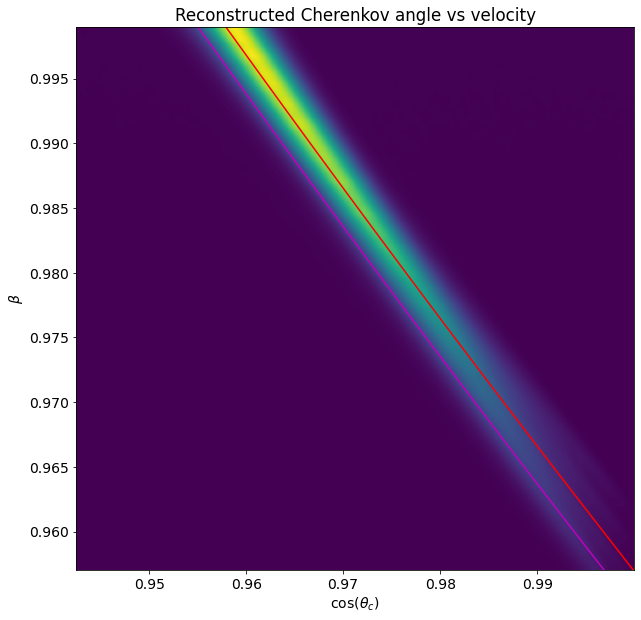

In [ ]:
H, xedges, yedges = np.histogram2d(np.cos(edf['theta_c']), edf['beta'], bins=(100,100))
H = H.T

plt.figure(figsize=(10,10))
# plot mesh-grid with variable aspect ratio
#X, Y = np.meshgrid(xedges, yedges)
#plt.pcolormesh(X, Y, H)

# plot with imshow
plt.imshow(H, interpolation='gaussian', origin='lower', aspect='auto',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
           cmap='viridis')

beta_t = np.linspace(0.957,0.999,100)
theta_ct = 1/1.045/beta_t
plt.plot(theta_ct, beta_t, 'r-')

beta_t = np.linspace(0.957,0.999,100)
theta_ct = 1/(0.6*1.05+0.4*1.0454)/beta_t
plt.plot(theta_ct, beta_t, 'm-')

# scatter plot
#plt.scatter(edf.head(1000000)['theta_c'], edf.head(1000000)['beta'], 0.05, 'b')
plt.title(r'Reconstructed Cherenkov angle vs velocity')
plt.xlabel(r'cos($\theta_c)$')
plt.ylabel(r'$\beta$')
plt.savefig(datadir+os.sep+'beta_vs_cos(theta_c)_2dplot.png')

In [ ]:
betas_classic = 1/np.cos(theta_average)/n_mean
dbeta_residual = betas_classic - beta_primary
thetas = np.around(np.array(thetas),6)
thetas = thetas/pi*2*90 # градусы
beta_primary = np.array(beta_primary)

In [ ]:
def gausSigmaWithError(data, iname: str, onames: tuple):
  assert(len(onames)==2)
  series = data[iname]
  mean, sd = series.mean(), series.std()
  q1, q2 = mean-3*sd, mean+3*sd
  cutseries = series[(q1<series)&(series<q2)]

  blh = BinnedLH(gaussian, cutseries, bins=100)
  m = Minuit(blh, mean=cutseries.mean(), sigma=cutseries.std())
  m.errordef = Minuit.LIKELIHOOD

  r = m.migrad() # fit

  return pd.Series((m.values[1], m.errors[1]), index=(onames[0], onames[1]))

95126 95126


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: LogWarning: x is really small return 0
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: LogWarning: x is really small return 0
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: LogWarning: x is really small return 0
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: LogWarning: x is really small return 0
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: LogWarning: x is really small return 0
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: LogWarning: x is really small return 0
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: LogWarning: x is really small return 0
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: LogWarning: x is really small return 0


Minimum fitted gaussian sigma among theta_p-beta bins: 0.022404747672868704


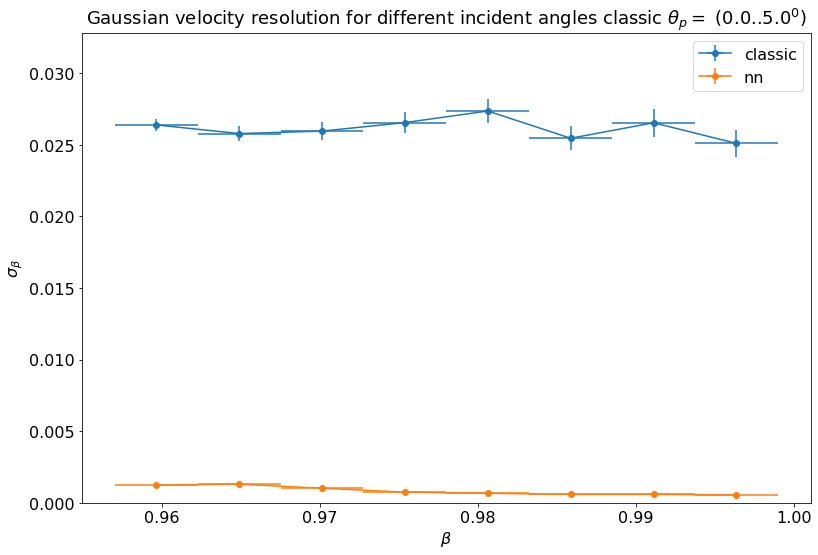

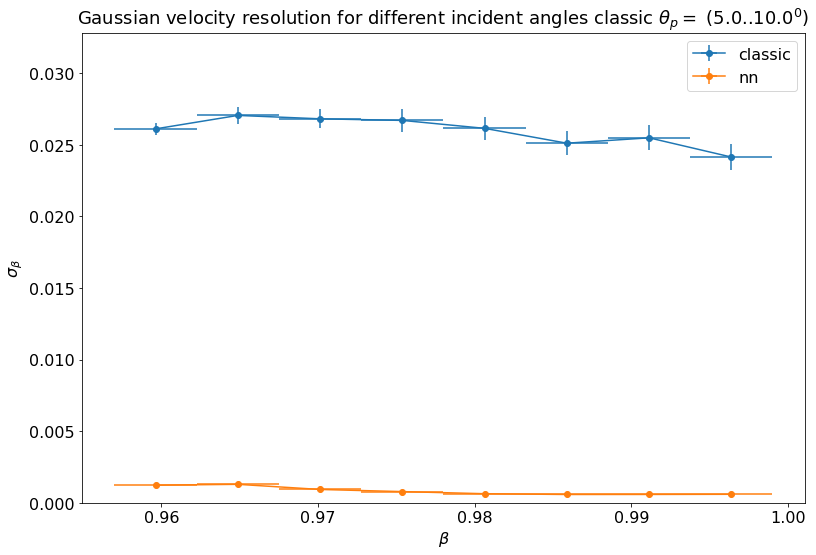

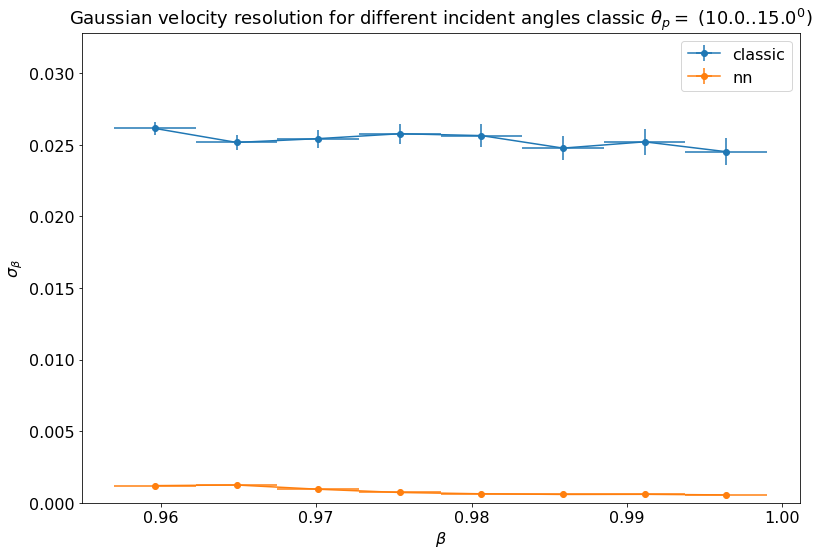

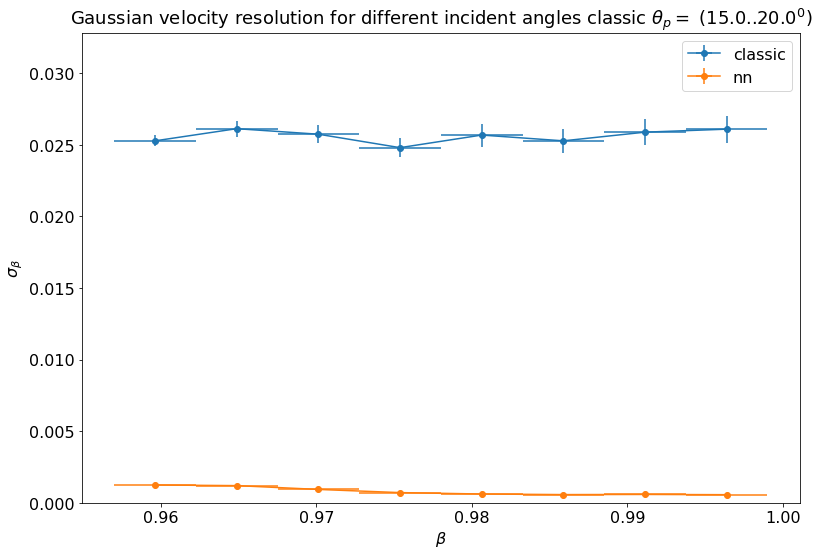

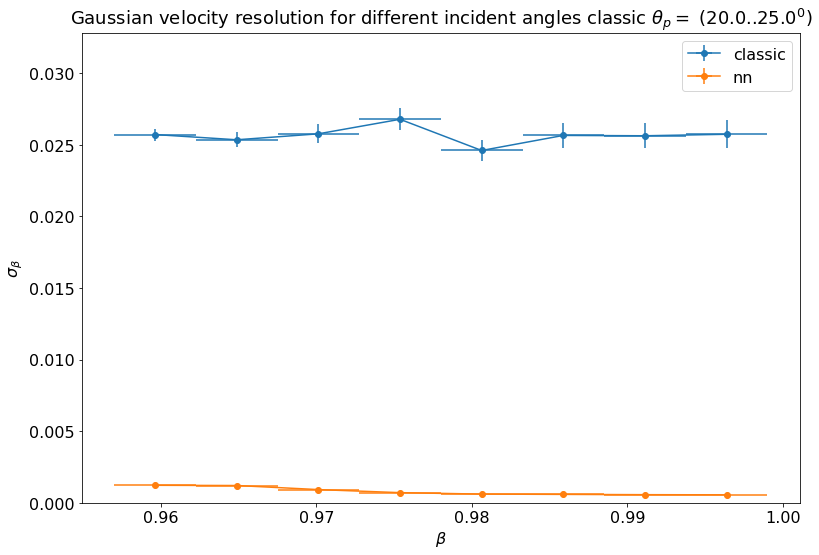

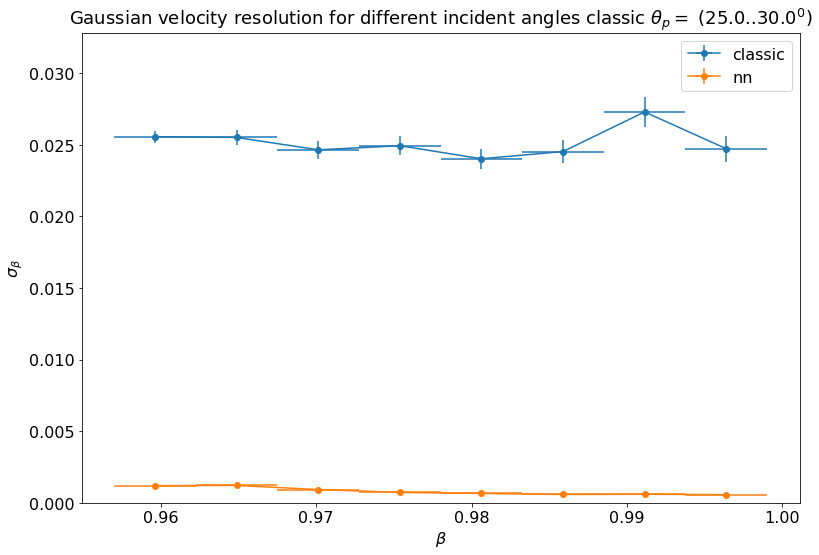

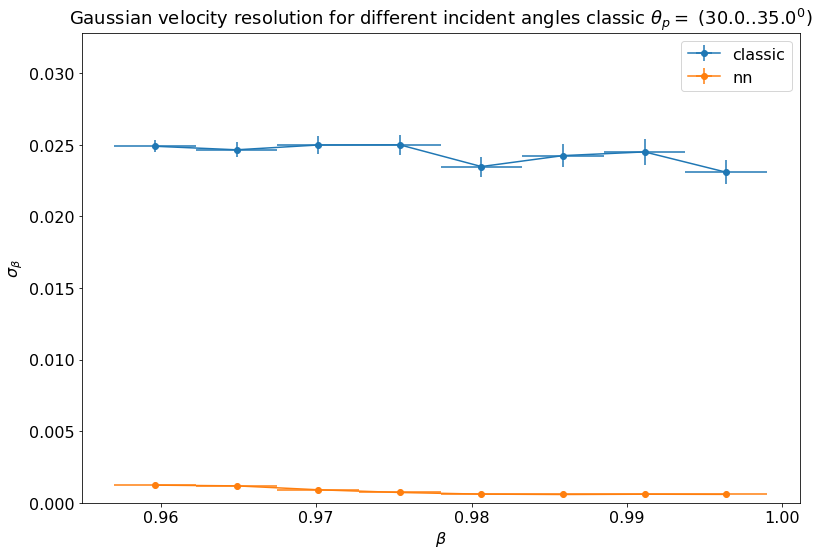

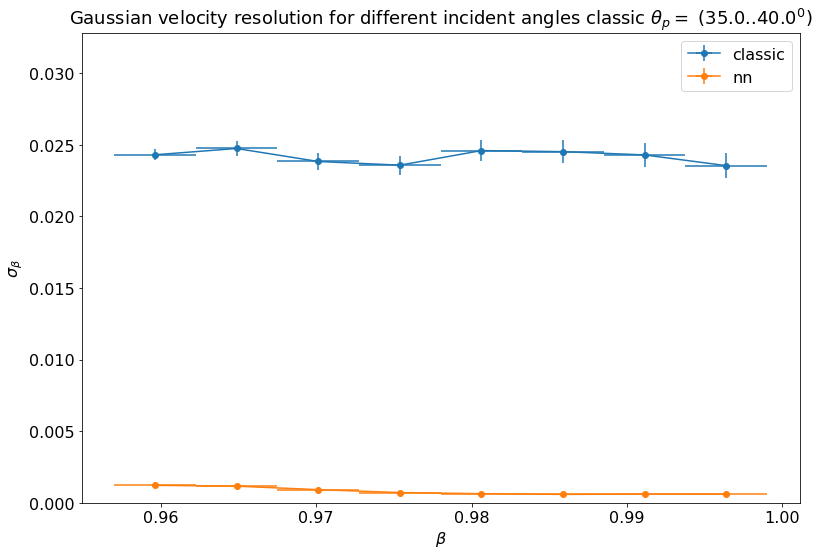

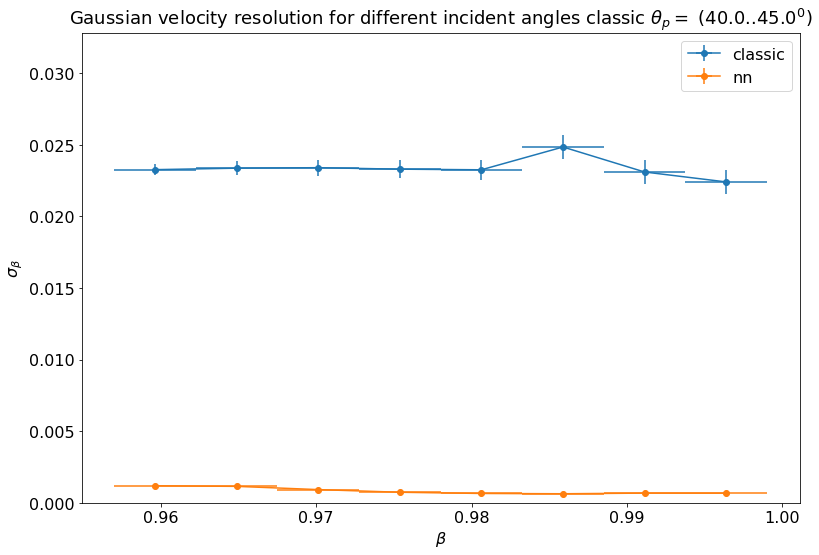

In [ ]:

nbetapnts, nthetapnts = 8, 9
beta_min, beta_max = beta_primary.min(), beta_primary.max()+1e-5
theta_min, theta_max = 0., thetas.max()+1e-4
beta_pnt = beta_min + (beta_max-beta_min) * (np.floor(nbetapnts * (beta_primary-beta_min) / (beta_max-beta_min)) + 0.5) / nbetapnts
theta_pnt = theta_min + (theta_max-theta_min) * (np.floor(nthetapnts * (thetas-theta_min) / (theta_max-theta_min)) + 0.5) / nthetapnts
beta_set, theta_set = np.unique(beta_pnt), np.unique(theta_pnt)
dbeta = (beta_max - beta_min) / nbetapnts / 2
dtheta = (theta_max - theta_min) / nthetapnts / 2

print(beta_pnt.size,theta_pnt.size)
resdf = pd.DataFrame({'beta_pnt': beta_pnt, 'theta_pnt': theta_pnt, 'residual': beta_residual}, dtype=np.float64)
resdfgrp = resdf.groupby(['beta_pnt', 'theta_pnt'])
accdf = resdfgrp.mean()
accdf.columns = ['shift']
accdf = accdf.join(resdfgrp.apply(gausSigmaWithError, iname='residual', onames=('sigma', 'sigma_error')), )
print('Minimum fitted gaussian sigma among theta_p-beta bins:', min(accdf['sigma']))
accdf.reset_index(('beta_pnt', 'theta_pnt'), inplace=True)
accdf.sort_values(['theta_pnt', 'beta_pnt'], ascending=True, inplace=True)

sbmax = 0      
for theta in theta_set:
  mask = np.isclose(accdf['theta_pnt'], theta)
  b, sb, esb = accdf.loc[mask, 'beta_pnt'].to_numpy(), accdf.loc[mask, 'sigma'].to_numpy(), accdf.loc[mask, 'sigma_error'].to_numpy()
  if sbmax < sb.max():
    sbmax = sb.max()
  plt.figure(figsize=(12,8))
  sigma_nn = np.load(datadir + os.sep + f'beta_sigma_save_{theta-dtheta:.1f}_{theta+dtheta:.1f}.npy')
  beta_nn = np.load(datadir + os.sep + f'beta_save_{theta-dtheta:.1f}_{theta+dtheta:.1f}.npy')
  sigma_nn_error = np.load(datadir + os.sep + f'beta_sigma_save_{theta-dtheta:.1f}_{theta+dtheta:.1f}_error.npy')
  beta_nn_eror = np.load(datadir + os.sep + f'beta_save_{theta-dtheta:.1f}_{theta+dtheta:.1f}_error.npy')      
  plt.errorbar(b, sb, xerr=dbeta, yerr=esb, fmt='-o', label=r'classic')
  plt.errorbar(beta_nn, sigma_nn, xerr=beta_nn_eror, yerr=sigma_nn_error, fmt='-o', label=r'nn')
  plt.xlabel(r'$\beta$', fontsize=16)
  plt.ylabel(r'$\sigma_{\beta}$', fontsize=16)
  plt.title(rf'Gaussian velocity resolution for different incident angles classic $\theta_p =$ ({theta-dtheta:.1f}..{theta+dtheta:.1f}$^0$)', fontsize=18)
  plt.legend(fontsize=16)
  plt.ylim(0, 1.2*sbmax)
  plt.tight_layout()
  plt.savefig(datadir + os.sep + 'beta'+rf'_gaus_resolution_1d_classic_$\theta_p =$ ({theta-dtheta:.1f}..{theta+dtheta:.1f}$^0$).png')